In [42]:
import os
import numpy as np
import matplotlib.pyplot as plt

from skimage import color
from torch.utils.data import *
from torchvision import datasets, models, transforms

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
!gdown --id 1_q37TRIFwtwhmSeLu_4h3SkFHrDSjeyl

Downloading...
From: https://drive.google.com/uc?id=1_q37TRIFwtwhmSeLu_4h3SkFHrDSjeyl
To: /content/pfcn_small.npz
137MB [00:02, 66.3MB/s]


In [3]:
pfcn_small = np.load('pfcn_small.npz')
print(pfcn_small.files)

['train_images', 'test_images', 'train_mattes', 'test_mattes']


In [4]:
train_images = pfcn_small['train_images']
train_mattes = pfcn_small['train_mattes']
test_images = pfcn_small['test_images']
test_mattes = pfcn_small['test_mattes']

(1700, 100, 75, 3)

In [5]:
print("Max value :", np.max(train_images), "\nMin value :", np.min(train_images))

Max value : 1.0 
Min value : 0.0


In [6]:
def imshow(files, nums):
    # numpy : (batch_num, height, width, channel)
    height, width, channel = files[0].shape
    img = files[:nums].transpose([1, 0, 2, 3]).reshape((height, -1 ,channel))
    plt.imshow(img)
    plt.show()    

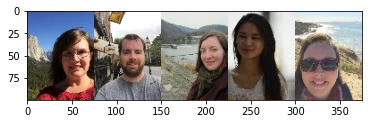

In [ ]:
imshow(train_images, 5)

In [23]:
lr = 0.001
batch_size = 64
num_epochs = 10

In [9]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

In [43]:
class CustomDataset(Dataset):
    def __init__(self, x, y, transform = None):
        super(CustomDataset, self).__init__()
        x = x.transpose([0, 3, 1, 2])
        y = np.array([color.rgb2gray(img).reshape((100, 75, 1)) for img in y])

        self.x_data = torch.from_numpy(x).float().to(DEVICE)
        self.y_data = torch.from_numpy(y.transpose([0, 3, 1, 2])).float().to(DEVICE)
        self.transform = transform

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x, y = self.x_data[idx], self.y_data[idx]
        data = {'x':x, 'y':y}

        if self.transform is not None:
            data = self.transform(data)

        return data   

In [44]:
train_dataset = CustomDataset(train_images, train_mattes)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CustomDataset(test_images, test_mattes)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [45]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 13 * 10, 10)
        )
    
        self.decoder = nn.Sequential(
            nn.Linear(10, 16640),
            Reshape(-1, 128, 13, 10),
            nn.ConvTranspose2d(128, 64, 3, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 2, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, (2, 1), 2),
            nn.ReLU(),
            nn.ConvTranspose2d(1, 1, 1, 1)
        )
    
    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)
        return out

    def get_codes(self, x):
        return self.encoder(x)

In [46]:
from torchsummary import summary 
model = AutoEncoder().cuda()
summary(model, (3, 100, 75))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 50, 38]             896
              ReLU-2           [-1, 32, 50, 38]               0
            Conv2d-3           [-1, 64, 25, 19]          18,496
              ReLU-4           [-1, 64, 25, 19]               0
            Conv2d-5          [-1, 128, 13, 10]          73,856
              ReLU-6          [-1, 128, 13, 10]               0
           Flatten-7                [-1, 16640]               0
            Linear-8                   [-1, 10]         166,410
            Linear-9                [-1, 16640]         183,040
          Reshape-10          [-1, 128, 13, 10]               0
  ConvTranspose2d-11           [-1, 64, 25, 19]          73,792
             ReLU-12           [-1, 64, 25, 19]               0
  ConvTranspose2d-13           [-1, 32, 50, 38]           8,224
             ReLU-14           [-1, 32,

In [47]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [24]:
train_dataset = CustomDataset(train_images, train_mattes)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CustomDataset(test_images, test_mattes)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
for epoch in range(num_epochs):

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        x, y = data['x'], data['y']

        optimizer.zero_grad()

        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i + 1) % 10 == 0:
            print(f'Epoch:{epoch}/{num_epochs-1}, current lr:{i + 1}, running loss:{running_loss}')
            running_loss = 0.0

print('Finished Training')

Epoch:0/9, current lr:10, running loss:2.3186748027801514
Epoch:0/9, current lr:20, running loss:2.325688585639
Epoch:1/9, current lr:10, running loss:2.3098352402448654
Epoch:1/9, current lr:20, running loss:2.3251054733991623
Epoch:2/9, current lr:10, running loss:2.3052082657814026
Epoch:2/9, current lr:20, running loss:2.3313305974006653
Epoch:3/9, current lr:10, running loss:2.316448152065277
Epoch:3/9, current lr:20, running loss:2.313985973596573
Epoch:4/9, current lr:10, running loss:2.3283647000789642
Epoch:4/9, current lr:20, running loss:2.3184299767017365
Epoch:5/9, current lr:10, running loss:2.3406374752521515
Epoch:5/9, current lr:20, running loss:2.305915728211403
Epoch:6/9, current lr:10, running loss:2.31707364320755
Epoch:6/9, current lr:20, running loss:2.320688247680664
Epoch:7/9, current lr:10, running loss:2.3244636803865433
Epoch:7/9, current lr:20, running loss:2.319374606013298
